# Comparison of two approaches to efficient communication applied to modals

### Define the modals universe

In [1]:
from ultk.language.semantics import Referent, Universe
from ultk.effcomm.informativity import informativity
import numpy as np
import pandas as pd

universe = Universe.from_csv("./data/universe.csv")

### Define the measure of informativity

Using a 'half-credit' communictive utility scoring and a corpus-estimated prior over meanings

In [2]:
def half_credit_utility(m: Referent, m_: Referent) -> float:
    score = 0.0
    if m.force == m_.force:
        score += 0.5
    if m.flavor == m_.flavor:
        score += 0.5
    return score

modal_informativity = lambda lang: informativity(lang, universe.prior_numpy, half_credit_utility)

### Define complexity as length in a boolean grammar

In [3]:
from ultk.language.grammar import Grammar, GrammaticalExpression
from ultk.language.language import Expression, Meaning, Language, aggregate_expression_complexity

In [4]:
grammar = Grammar.from_yaml("./data/grammar.yaml")
grammar

expressions_by_meaning: dict[Meaning, Expression] = grammar.get_unique_expressions(
    depth=5,
    max_size=2 ** len(universe) + 1,
    unique_key=lambda expr: expr.evaluate(universe),
    compare_func=lambda e1, e2: len(e1) < len(e2),
)
expressions_by_meaning = {key: value for key, value in expressions_by_meaning.items() if not key.is_uniformly_false()} # exclude bottom

In [5]:
def complexity(
    language: Language, expressions_by_meaning: dict[Meaning, GrammaticalExpression]
) -> float:
    """Get complexity of a language via minimal expression length in LoT.

    Args:
        language: the Language to measure
        expressions_by_meaning: a dictionary with keys as `Meaning`s, that returns the shortest GrammaticalExpression which expresses that Meaning

    Returns:
        sum of the length of the shortest LoT expression for each meaning in the language
    """
    return aggregate_expression_complexity(
        language, lambda expr: len(expressions_by_meaning[expr.meaning])
    )

boolean_complexity = lambda lang: complexity(lang, expressions_by_meaning)

### Load natural languages

We download natural languages, one CSV at a time, from a public repo and convert each to a Language. See `util.py` for more details.

In [6]:
from util import load_natural_languages
natural_languages = load_natural_languages()

Loading modals data from https://api.github.com/repos/nathimel/modals-effcomm/contents/data/natural_languages?ref=main


 79%|███████▉  | 23/29 [00:03<00:00,  6.57it/s]

Data for Qiang is of type reference-grammar; skipping.


100%|██████████| 29/29 [00:04<00:00,  5.84it/s]

Adding Akan
Adding Basque
Adding Cantonese
Adding Dutch
Adding Farsi
Adding Gitksan
Adding Greek
Adding Hausa
Adding Hebrew
Adding Hindi
Adding Hungarian
Adding Igbo
Adding Japanese
Adding Javanese-Paciran
Adding Khmer
Adding Kiitharaka
Adding Korean
Adding Lillooet-Salish
Adding Logoori
Adding Mandarin
Adding Mapudungun
Adding Russian
Adding Tagalog
Adding Telugu
Adding Thai
Adding Tlingit
Adding Turkish
Adding Vietnamese


##### Define a lexical semantic universal to measure

In [7]:
import itertools

def iff(e: Expression) -> bool:
    """Whether an expression satisfies the Independence of Forces and Flavors Universal.

    The set of forces X that a modal lexical item m can express and the set of flavors be Y that m can express, then the full set of meaning points that m expresses is the Cartesian product of X and Y.
    """
    points = {(ref.force, ref.flavor) for ref in e.meaning.mapping if e.meaning.mapping[ref]}
    forces = {point[0] for point in points}
    flavors = {point[1] for point in points}

    if any((force, flavor) not in points for force, flavor in itertools.product(forces, flavors)):
        return False
    return True


### Measure languages

In [8]:
from tqdm import tqdm

def langs_to_df(languages: list[Language], properties_to_add: dict) -> pd.DataFrame:
    return pd.DataFrame.from_records(
        [
            {key: lang_dict[key] for key in properties_to_add} for lang_dict in 
            [
                language.as_dict_with_properties(
                    **{key: properties_to_add[key](idx, language) for key in properties_to_add}
                )
            for idx, language in tqdm(enumerate(languages), total=len(languages))
            ]
        ]
    )

In [9]:
natural_df = langs_to_df(
    natural_languages,
    {
        "name": lambda _, lang: lang.name,
        "type": lambda _1, _2: "natural",
        "boolean_complexity": lambda _, lang: boolean_complexity(lang),
        "literal_informativity": lambda _, lang: modal_informativity(lang),
        "iff": lambda _, lang: lang.degree_property(iff),
    }
)


100%|██████████| 28/28 [00:00<00:00, 2142.29it/s]


### Estimate pareto frontier

In [10]:
from ultk.effcomm.optimization import EvolutionaryOptimizer
from ultk.language.sampling import random_languages

In [11]:
expressions = list(expressions_by_meaning.values())

seed_languages = random_languages(
    expressions, sampling_strategy="stratified", sample_size=1000, max_size=10
)

# Evolutionary optimizer wants to minimize two objectives
objectives = [boolean_complexity, lambda lang: 1 - modal_informativity(lang)]

optimizer = EvolutionaryOptimizer(
    objectives,
    expressions,
    1000,
    3,
    50,
)
result = optimizer.fit(seed_languages)

100%|██████████| 50/50 [00:15<00:00,  3.13it/s]


In [12]:
dominating_df = langs_to_df(
    result["dominating_languages"], 
    {
        "name": lambda idx, _: f"dominating-{idx}",
        "type": lambda _1, _2: "dominant",
        "boolean_complexity": lambda _, lang: boolean_complexity(lang),
        "literal_informativity": lambda _, lang: modal_informativity(lang),
        "iff": lambda _, lang: lang.degree_property(iff),        
    },    
)

explored_df = langs_to_df(
    result["explored_languages"],
    {
        "name": lambda idx, _: f"explored-{idx}",
        "type": lambda _1, _2: "explored",
        "boolean_complexity": lambda _, lang: boolean_complexity(lang),
        "literal_informativity": lambda _, lang: modal_informativity(lang),
        "iff": lambda _, lang: lang.degree_property(iff),
    },
)

100%|██████████| 15233/15233 [00:05<00:00, 2844.37it/s]


## Information Bottleneck analysis

Define the domain distribution $p(U|M)$ and $p(M)$

In [13]:
from ultk.effcomm.information_bottleneck.modeling import pU_M_from_similarity, get_ib_naming_model

In [14]:
similarity_matrix = np.array([[half_credit_utility(m, m_) for m_ in universe] for m in universe])
pM = universe.prior_numpy

# Here we use an arbitrary value of gamma for parameterizing a similarity-based distributions that will produce a nontrivial bound
pU_M = pU_M_from_similarity(1e-1, similarity_matrix)

In [15]:
betas = np.logspace(0, 5, 1000,)
naming_model = get_ib_naming_model(
    pU_M, pM, betas=betas,
)

beta=1.00000: 100%|██████████| 1000/1000 [00:46<00:00, 21.72it/s]     


#### Define the mapping between a Language and an IB encoder

In [16]:
def lang_to_encoder(language: Language) -> np.ndarray:
    """Simplifying assumption here that p(w) is uniform."""
    pM_W = np.array([list(expr.meaning.dist.values()) for expr in language.expressions])
    return pM_W.T / pM_W.T.sum(axis=1, keepdims=True)


In [17]:
natural_encoders = [lang_to_encoder(lang) for lang in tqdm(natural_languages)]
dominating_encoders = [lang_to_encoder(lang) for lang in tqdm(result["dominating_languages"])]
explored_encoders = [lang_to_encoder(lang) for lang in tqdm(result["explored_languages"])]

100%|██████████| 15233/15233 [00:00<00:00, 27037.96it/s]


Measure natural languages on information plane

In [18]:
def add_ib_plane_columns(df: pd.DataFrame, encoders: list[np.ndarray]) -> pd.DataFrame:
    # df["ib_complexity"], df["ib_accuracy"] = np.array([(naming_model.complexity(enc), naming_model.accuracy(enc)) for enc in tqdm(encoders)]).T
    measurements = []
    for enc in tqdm(encoders):
        comp = naming_model.complexity(enc)
        acc = naming_model.accuracy(enc)
        eps, gnid, bl, _ = naming_model.fit(enc)
        measurements.append((comp, acc, eps, gnid, bl))
    arr = np.array(measurements)

    df["ib_complexity"] = arr[:, 0]
    df["ib_accuracy"] = arr[:, 1]
    df["min_epsilon"] = arr[:, 2]
    df["fitted_beta"] = arr[:, 3]
    return df


natural_df = add_ib_plane_columns(natural_df, natural_encoders)
dominating_df = add_ib_plane_columns(dominating_df, dominating_encoders)
explored_df = add_ib_plane_columns(explored_df, explored_encoders)

  4%|▍         | 665/15233 [00:00<00:02, 6646.41it/s]/Users/nathanielimel/uw/projects/ultk/src/ultk/effcomm/information_bottleneck/modeling.py:154: UserWarning: Negative gNID: -0.019719326541894455.
  warnings.warn(f"Negative gNID: {score}.")
  9%|▊         | 1330/15233 [00:00<00:02, 6490.71it/s]/Users/nathanielimel/uw/projects/ultk/src/ultk/effcomm/information_bottleneck/modeling.py:154: UserWarning: Negative gNID: -0.07196422772899025.
  warnings.warn(f"Negative gNID: {score}.")
 78%|███████▊  | 11861/15233 [00:01<00:00, 6497.20it/s]/Users/nathanielimel/uw/projects/ultk/src/ultk/effcomm/information_bottleneck/modeling.py:154: UserWarning: Negative gNID: -0.023615920126810463.
  warnings.warn(f"Negative gNID: {score}.")
 82%|████████▏ | 12511/15233 [00:01<00:00, 5807.16it/s]/Users/nathanielimel/uw/projects/ultk/src/ultk/effcomm/information_bottleneck/modeling.py:154: UserWarning: Negative gNID: -0.06758893511879727.
  warnings.warn(f"Negative gNID: {score}.")
/Users/nathanielimel/uw/p

In [19]:
# Lastly, load a dataframe of the ib bound.
ib_bound_df = pd.DataFrame(naming_model.IB_curve.T, columns=["ib_complexity","ib_accuracy"])

## Compare with visualizations

In [20]:
import plotnine as pn

#### boolean complexity vs. literal informativity

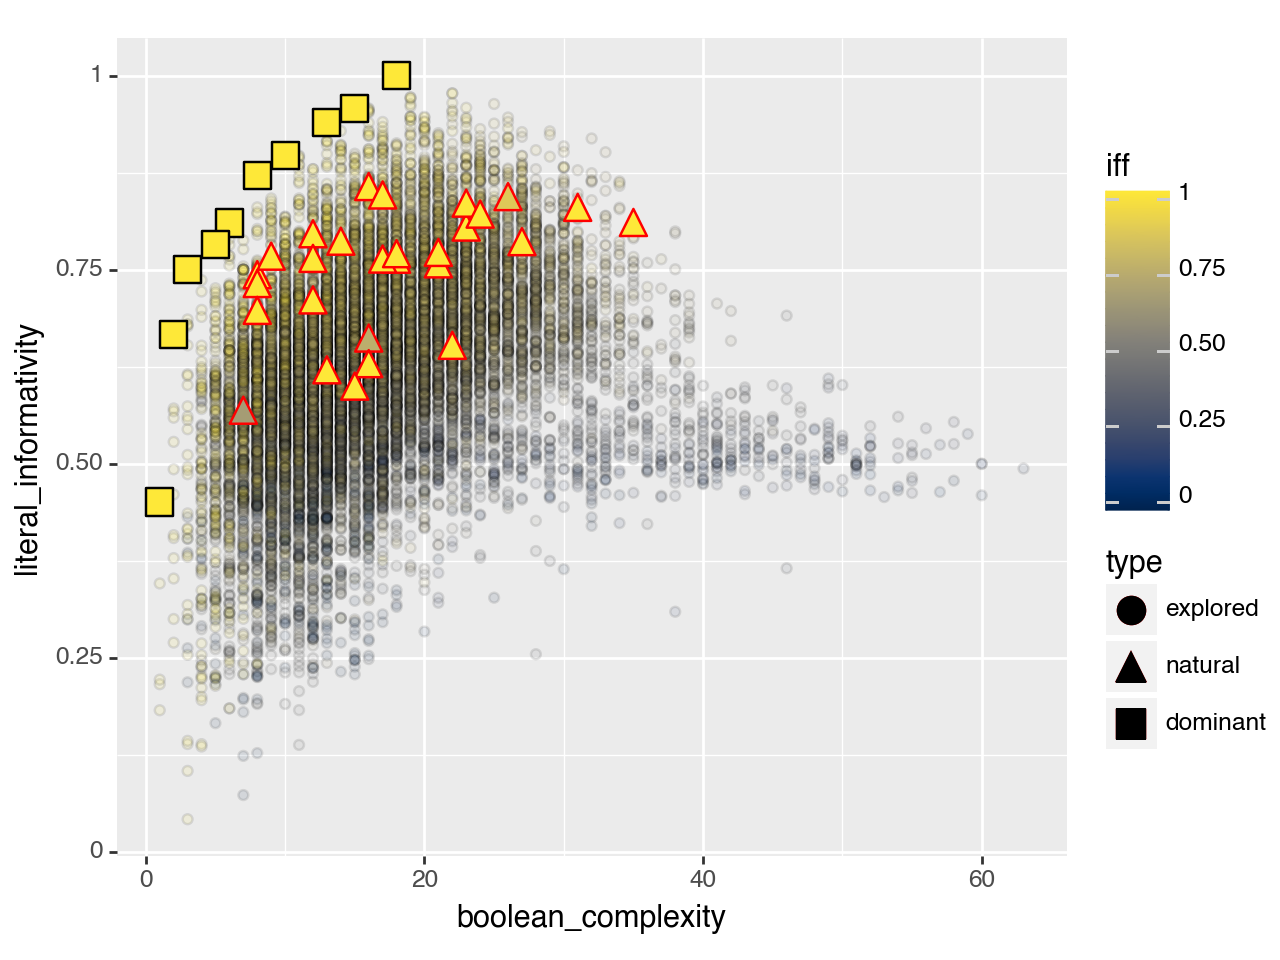

<Figure Size: (640 x 480)>

In [21]:
(
    pn.ggplot(
        explored_df,
        pn.aes(
            x="boolean_complexity",
            y="literal_informativity",
        ),
    )
    + pn.geom_point(
        # color="gray",
        pn.aes(
            fill="iff",
            shape="type",
        ),     
        alpha=0.1,
    )
    + pn.geom_point(
        natural_df,
        pn.aes(
            fill="iff",
            shape="type",
        ),
        color="red",
        size=5,
    )
    + pn.geom_point(
        dominating_df,
        pn.aes(
            fill="iff",
            shape="type",
        ),        
        color="black",
        size=5,
    )
    + pn.scale_fill_continuous("cividis")
)

#### IB

/Users/nathanielimel/miniforge3/envs/ultk/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 5217 rows containing missing values.
/Users/nathanielimel/miniforge3/envs/ultk/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 4 rows containing missing values.
/Users/nathanielimel/miniforge3/envs/ultk/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 4 rows containing missing values.


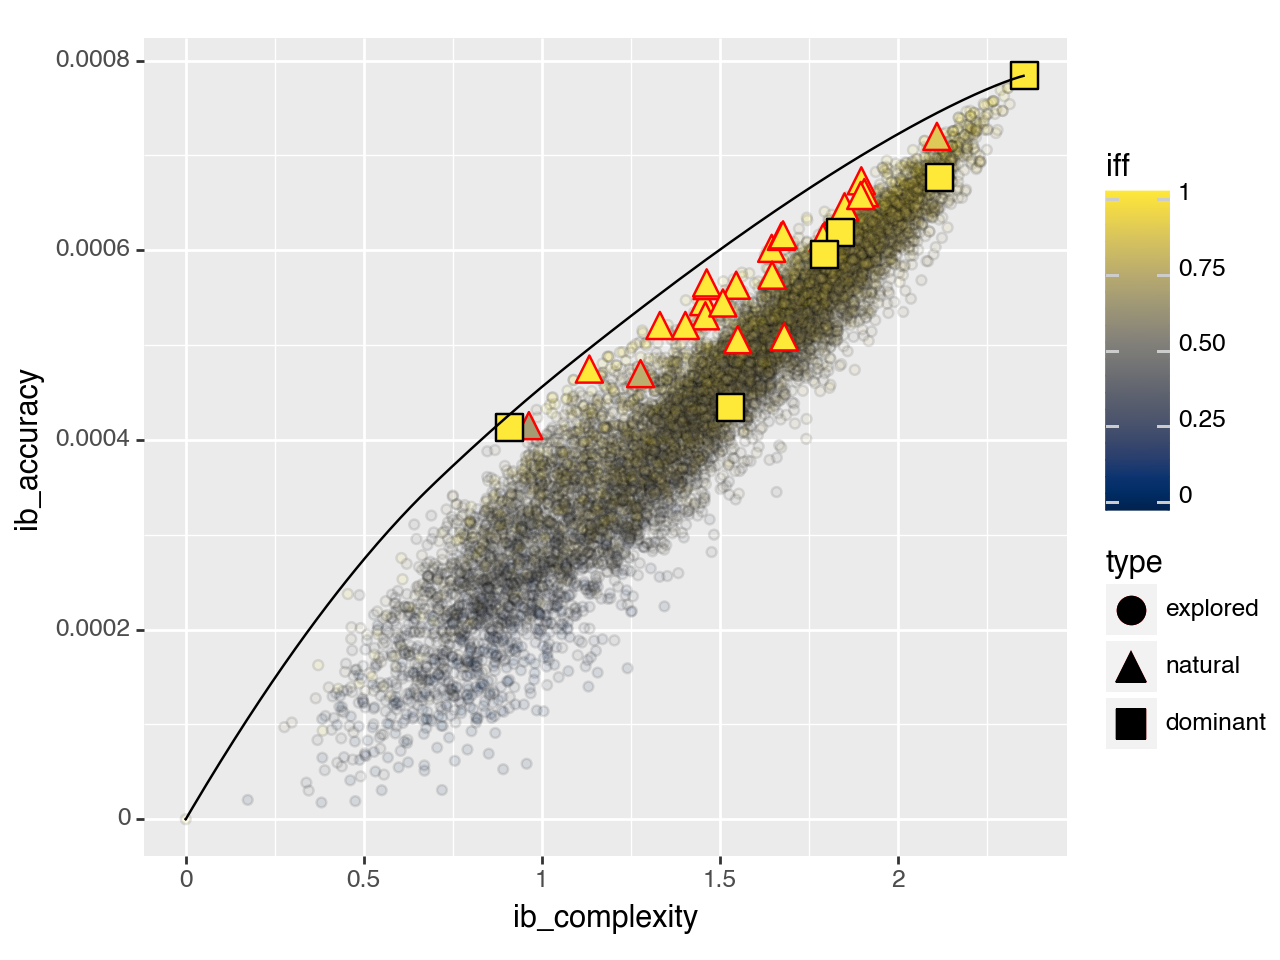

<Figure Size: (640 x 480)>

In [22]:
(
    pn.ggplot(
        explored_df,
        pn.aes(
            x="ib_complexity",
            y="ib_accuracy",
        ),
    )
    + pn.geom_point(
        # color="gray",
        pn.aes(
            fill="iff",
            shape="type",
        ),     
        alpha=0.1,
    )
    + pn.geom_point(
        natural_df,
        pn.aes(
            fill="iff",
            shape="type",
        ),
        color="red",
        size=5,
    )
    + pn.geom_point(
        dominating_df,
        pn.aes(
            fill="iff",
            shape="type",
        ),        
        color="black",
        size=5,
    )
    + pn.geom_line(
        ib_bound_df,
        color="black",
    )
    + pn.scale_fill_continuous("cividis")
)

#### some notes

- We showed how to directly compare two approaches to efficient communication analyses of language, using modal typological data as a test case
- Interestingly, while natural languages appear to optimize both (1) a trade-off between boolean complexity and literal informativity and (2) a trade-off between information theoretic complexity and accuracy as defined by the Information Bottleneck framework, there are significant qualitative and quantitative predictions between each analysis. In particular, neither measures of complexity or informativeness are perfectly correlated; some languages that are dominating in the evolutionary algorithm are significantly more sub-optimal than natural languages in the IB analysis here.
- There are multiple choice points involved in both approaches. 
  - For boolean/grammatical complexity, one must hand-specify a grammar corresponding to an internal representation language (i.e. an LoT) for the domain. 
  - We could have chosen various pragmatic measures of informativity.
  -  In IB, it is crucial to define the domain in terms of meaning distributions that are not deterministic -- and here $\gamma$ is a free parameter. 
  -  More generally, ULTK's EvolutionaryOptimizer can be used to search for heuristic solutions to multi-objective, non-convex optimization problems as defined by any pair of language measures, including those inherent to IB.
  -  In IB, there are information-theoretically optimal solutions for efficient compression in a particular domain. In this example, we have successfully computed this bound. However, for universes of large cardinality, the IB Blahut-Arimoto algorithm becomes slow or infeasible.
